In [1]:
# Section 1
import numpy as np
import pandas as pd
import scipy.io as sio
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
 
from cal_MISDC_SEMIDISTR_continuous_Lakes import cal_MISDC_SEMIDISTR_continuous_Lakes
from cal_MISDC_SEMIDISTR_continuous_Lakes_allsez import cal_MISDC_SEMIDISTR_continuous_Lakes_allsez
from MISD_SEMIDISTR_continuous_model import MISD_SEMIDISTR_continuous_Lakes_irrig_waterUses_MODIrrRes_Pd
from Water_use import calculate_water_use
from perf import perf
from klingupta import klinggupta

In [ ]:
# Section 2
file_path = 'topologia_LakesPo.csv'  
TOPOL = pd.read_csv(file_path, sep='\s+', header=None)

TOPOL.head()
TOPOL.loc[TOPOL[3] == 0, 3] = 2
TOPOL.loc[TOPOL[3] == -1, 3] = 1

inpdata = np.load("basin_data_Po.npz", allow_pickle=True)
basin_data = inpdata["basin_data"].tolist()

ID_irr_bas = np.load('ID_irr_Po.npz', allow_pickle=True)
ID_irr_bas_DIST = ID_irr_bas['ID_irr'] 

with open('ID_bas_app.txt', 'r') as file:
    ID_bas_app = [int(line.strip()) for line in file]


distance_data = np.loadtxt(f'distance_Po_allbas.txt')
EBRR_BASPAR = np.column_stack([TOPOL.iloc[:, 0], distance_data, TOPOL.iloc[:, 5], TOPOL.iloc[:, 3]])

BAS_PAR = np.array([TOPOL.shape[0], TOPOL.shape[0], 0])
Lake = np.array([
    [33, 420 * 10**6, np.nan],
    [46, 246.5 * 10**6, np.nan],
    [62, 85.4 * 10**6, np.nan],
    [75, 458 * 10**6, 150]
])

sez_outlet = 14
bas_check = ID_bas_app[sez_outlet - 1]

In [ ]:
# # Section 3
# sez_cal = [21, 44, 77, 92]

# X_OPT = np.loadtxt('X_opt_sezMult_Po_Lakes_irr_KGE_0323_HRT.txt')  # Load the optimized parameters
# LOW = np.array([0.1, 300, 2.0, 0.10, 0.5, 0.4, 1.0, 0.1 / 24, 5.0, 0.01, 1, 1]).reshape(12,1)
# UP = np.array([0.9, 4000, 10.0, 20.0, 3.5, 2.0, 15.0, 3, 20.0, 45.0, 60, 30]).reshape(12,1)
# X_0 = (X_OPT - LOW) / (UP - LOW)
# X_ini = X_0

# X_OPTmod = np.ones((12, BAS_PAR[0])) * 0.5  
# IDall = []

# for i in range(len(sez_cal)):
#     ID = np.where(EBRR_BASPAR[:, sez_cal[i]] != -1)[0]    
#     IDdel = np.isin(ID, IDall)  
#     ID = ID[~IDdel]  
   
#     if i == len(sez_cal) - 3 or i == len(sez_cal) - 2 or i == len(sez_cal)-1:
#         X = cal_MISDC_SEMIDISTR_continuous_Lakes_allsez(basin_data, BAS_PAR, EBRR_BASPAR, sez_cal[i], sez_cal[i], ID_bas_app, Lake, ID_irr, ID, X_OPTmod)
#         X_OPTmod[:, ID] = X[:, ID]
#     else:
#         X_OPT = cal_MISDC_SEMIDISTR_continuous_Lakes(basin_data, BAS_PAR, EBRR_BASPAR, sez_cal[i], sez_cal[i], ID_bas_app, Lake, ID_irr)
#         if X_OPT.shape[0] == 12:
#             X_OPTmod[:, ID] = np.tile(X_OPT[:, 0:1], (1, len(ID)))
#         else:
#             X_OPTmod[:, ID] = X_OPT[:, 0:1] @ np.ones((1, len(ID)))
        
#     IDall.extend(ID.tolist())
#     # Save intermediate results
#     np.save(f'X_OPTmod_sez{sez_cal[i]}Lakes_irr_1722N.npy', X_OPTmod)

# # Save final results
# np.savetxt(f'X_opt_sez14_Po_Lakes_irr_KGE_1722N_HI_Pop_py.txt', X, fmt='%f', delimiter='\t')

In [4]:
# Section 4
X_OPT = np.loadtxt(f'E:/python_codes/X_opt_sezMult_Po_Lakes_irr_KGE_0323_HRT.txt')

# Run the irrigation model simulation
start_time = time.time()
(NS_sez_IRR, KGE_sez_IRR, KGE_out_IRR, Qsim_out_IRR, Stor_IRR, WW_IRR, WW2_IRR, Vol_IRRmod, SWE_IRR, E_IRR) = MISD_SEMIDISTR_continuous_Lakes_irrig_waterUses_MODIrrRes_Pd(basin_data, BAS_PAR, EBRR_BASPAR, X_OPT, bas_check, bas_check, ID_bas_app, Lake, ID_irr_bas_DIST, 1, include_irrigation=True, include_reservoirs=True)    
end_time = time.time()




e:\Github\MISD_SEMIDISTR_continuous_model.py:473: RuntimeWarning: Mean of empty slice
  np.nansum((obs_data - np.nanmean(obs_data,axis=0))**2,axis=0))
e:\Github\MISD_SEMIDISTR_continuous_model.py:472: RuntimeWarning: invalid value encountered in divide
  NS_sez = 1 - (np.nansum((Qsim1 - obs_data)**2,axis=0) /


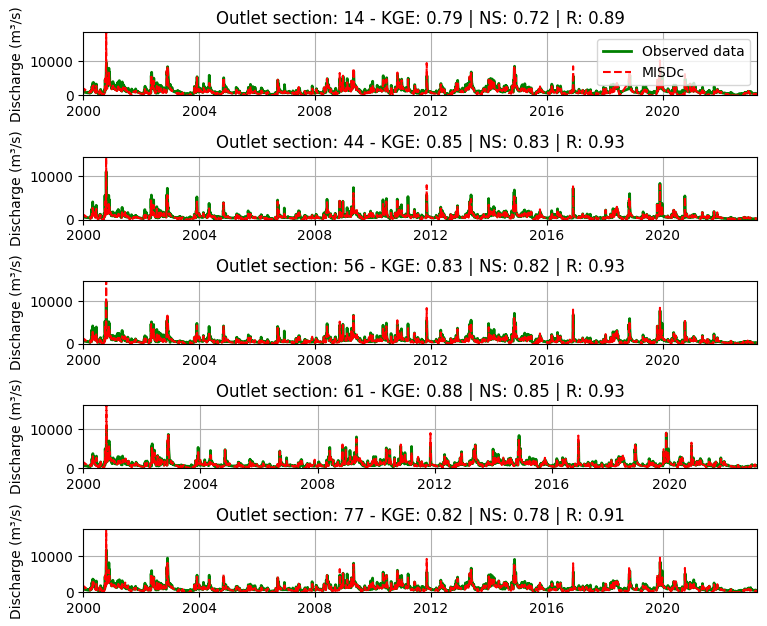

In [5]:
# Section 5
time_data = basin_data[0]['dates'].astype('datetime64[ns]')

# Create figure with specified size
plt.figure(figsize=(7.77, 6.36))

# Define basin check indices
ID_bas_checkinn = [44, 56, 61, 77]

# Create 5 subplots
for i in range(5):
    plt.subplot(5, 1, i+1)

    if i == 0:
        Qobs = basin_data[bas_check-1]['discharge']
        QQ = Qsim_out_IRR[:, bas_check-1]
        sez_outlet_num = sez_outlet  
    else:
        sez_outletinn = ID_bas_checkinn[i-1]
        Qobs = basin_data[sez_outletinn-1]['discharge']
        QQ = Qsim_out_IRR[:, sez_outletinn-1]
        sez_outlet_num = sez_outletinn

    # Clean data
    valid_indices = np.isfinite(Qobs) & np.isfinite(QQ)
    Qobs_clean = Qobs[valid_indices]
    QQ_clean = QQ[valid_indices]
    time_data_clean = time_data[valid_indices]

    # Plot
    plt.plot(time_data_clean, Qobs_clean, 'g-', linewidth=2, label='Observed data')
    plt.plot(time_data_clean, QQ_clean, 'r--', label='MISDc')

    # Set axis limits
    plt.xlim([time_data_clean[0], time_data_clean[-1]])
    plt.ylim([min(Qobs_clean.min(), QQ_clean.min()), 
              max(Qobs_clean.max(), QQ_clean.max())])

    # Calculate performance metrics
    NS, RMSE, ANSE, RQ, NS_lnQ, NS_radQ, KGE_out = perf(QQ_clean, Qobs_clean)
    kge = klinggupta(QQ_clean, Qobs_clean)

    if isinstance(NS, tuple): NS = NS[0]
    if isinstance(RQ, tuple): RQ = RQ[0]
    if isinstance(kge, tuple): kge = kge[0]

    # Add grid, box, labels, and title
    plt.grid(True)
    plt.box(True)
    plt.ylabel('Discharge (m³/s)')
    if i == 0:  
        plt.legend()
    plt.title(f'Outlet section: {sez_outlet_num} - KGE: {kge:.2f} | NS: {NS:.2f} | R: {RQ:.2f}')

plt.tight_layout()
plt.show()